# Modeling

## Objectives:
* Create a model that will predict the likelihood that an arrest will occur during a Terry Stop
* Determine which modeling method will bring about the best performance 

# Import Data

In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import euclidean
import xgboost as xgb
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Let's load the data and take a look at it.

In [2]:
df = pd.read_csv('CSV_Files/Terry_Stops_with_dummies.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.describe()

,stop_resolution,weapon_type,officer_id,officer_race,subject_perceived_race,initial_call_type,final_call_type,call_type,precinct,sector,...,frisk_flag__Y,dif_race__Y,dif_gender__Y,repeat_offenders__Y,subject_age_group__1_17,subject_age_group__26_35,subject_age_group__36_45,subject_age_group__46_55,subject_age_group__56_up,subject_age_group__Unknown
count,30364.000000,30364.000000,30364.000000,30364.000000,30364.000000,30364.000000,30364.000000,30364.000000,30364.000000,30364.000000,...,30364.000000,30364.000000,30364.000000,30364.000000,30364.000000,30364.000000,30364.000000,30364.000000,30364.000000,30364.000000
mean,2.174219,3.451060,633.057502,5.885094,4.400211,94.143426,69.522691,0.839679,2.817646,16.561586,...,0.258629,0.610789,0.278389,0.280760,0.048511,0.334409,0.209492,0.126235,0.049499,0.028619
std,1.002457,1.001798,256.704876,2.173229,2.772320,50.121144,35.351272,1.123204,2.353513,9.586147,...,0.437888,0.487579,0.448213,0.449378,0.214848,0.471791,0.406952,0.332120,0.216912,0.166737
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,472.000000,7.000000,1.000000,48.000000,42.000000,0.000000,1.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,647.000000,7.000000,5.000000,116.000000,83.000000,0.000000,2.000000,17.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,5.000000,835.000000,7.000000,7.000000,136.000000,94.000000,2.000000,6.000000,24.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,5.000000,1094.000000,7.000000,7.000000,162.000000,198.000000,3.000000,6.000000,34.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30364 entries, 0 to 30363
Data columns (total 32 columns):
stop_resolution                                  30364 non-null int64
weapon_type                                      30364 non-null int64
officer_id                                       30364 non-null int64
officer_race                                     30364 non-null int64
subject_perceived_race                           30364 non-null int64
initial_call_type                                30364 non-null int64
final_call_type                                  30364 non-null int64
call_type                                        30364 non-null int64
precinct                                         30364 non-null int64
sector                                           30364 non-null int64
beat                                             30364 non-null int64
incident_year                                    30364 non-null int64
incident_month                                   30

## Change to Floats
Ok, first order of business is to turn all of these columns into floats so that we can get more accurate statistical results.

In [4]:
for col in df.columns:
    df[col] = df[col].astype('float')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30364 entries, 0 to 30363
Data columns (total 32 columns):
stop_resolution                                  30364 non-null float64
weapon_type                                      30364 non-null float64
officer_id                                       30364 non-null float64
officer_race                                     30364 non-null float64
subject_perceived_race                           30364 non-null float64
initial_call_type                                30364 non-null float64
final_call_type                                  30364 non-null float64
call_type                                        30364 non-null float64
precinct                                         30364 non-null float64
sector                                           30364 non-null float64
beat                                             30364 non-null float64
incident_year                                    30364 non-null float64
incident_month             

Nice! Time to split up our data into targets and variables.

In [6]:
y = df['arrest_flag__Y']
X = df.drop('arrest_flag__Y', axis=1)

In [7]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42)

Next, we'll normalize the data so that the label encoded data isn't weighted as more important.

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

With that out of the way, lets start modeling!

# Logistic Regression
We'll start with a basic Logistic Regression

In [9]:
logreg = LogisticRegression(fit_intercept=False, C=1e16)

# Fitting the model

logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=1e+16, fit_intercept=False)

## Predictions
We'll make a function that will evaluate the predictions.

In [10]:
def logistic_predictions(X_train, X_test, y_train, y_test):
    """
    Input: Training and test sets of predictors 
    Output: The accuracy_score of each respective set. Percent correct(labeled 
    0.0) and percent incorrect(labeled as 1.0). 
    """
    
    y_hat_train = logreg.predict(X_train)
    y_hat_test = logreg.predict(X_test)
    
    train_residuals = np.abs(y_train - y_hat_train)
    print('Training Values',pd.Series(train_residuals).value_counts())
    print('------------------------------------')
    print('Training Accuracy',
          pd.Series(train_residuals).value_counts(normalize=True))
    
    test_residuals = np.abs(y_test - y_hat_test)
    print('Testing Values: ',pd.Series(test_residuals).value_counts())
    print('------------------------------------')
    print('Testing Accuracy: ',
          pd.Series(test_residuals).value_counts(normalize=True))

In [11]:
logistic_predictions(X_train_scaled, X_test_scaled, y_train, y_test)

Training Values 0.0    14020
1.0     7234
Name: arrest_flag__Y, dtype: int64
------------------------------------
Training Accuracy 0.0    0.659641
1.0    0.340359
Name: arrest_flag__Y, dtype: float64
Testing Values:  0.0    5917
1.0    3193
Name: arrest_flag__Y, dtype: int64
------------------------------------
Testing Accuracy:  0.0    0.649506
1.0    0.350494
Name: arrest_flag__Y, dtype: float64


### Interpretation
Results show that both the Training and Test sets are a little bit better than a coin flip, which is nothing to get excited over.  On the bright side, however, the accuracy between the two models is consistent (65-66%) so the model is not overfit or underfit, which is great!

## Confusion Matrix
We'll plot a Confusion Matrix to see the results

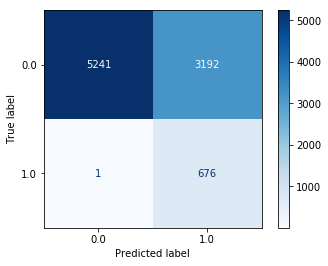

In [12]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(logreg, X_test_scaled, y_test, cmap=plt.cm.Blues)

plt.show()

With that in mind our Confusion Matrix tells us the following:
* True Positives = 676
* True Negatives = 5241
* False Positives = 3192
* False Negatives = 1

The extremely high number of False Positives is quite alarming.  It shows that there is definitely class imbalance in the dataset.

## Evaluation Metrics

In [13]:
y_hat_train = logreg.predict(X_train_scaled)
y_hat_test = logreg.predict(X_test_scaled)

In [14]:
def print_metrics(y_test, y_hat_test):
    print("Precision Score: {}".format(precision_score(y_test, y_hat_test)))
    print("Recall Score: {}".format(recall_score(y_test, y_hat_test)))
    print("Accuracy Score: {}".format(accuracy_score(y_test, y_hat_test)))
    print("F1 Score: {}".format(f1_score(y_test, y_hat_test)))
    
print_metrics(y_test, y_hat_test)

Precision Score: 0.17476732161323683
Recall Score: 0.9985228951255539
Accuracy Score: 0.6495060373216246
F1 Score: 0.29746974697469747


Ok, here is our problem! Our model is EXTREMELY under fit! Let's check out the class imbalance

In [15]:
y.value_counts()

0.0    28163
1.0     2201
Name: arrest_flag__Y, dtype: int64

There's our culprit! For every 1 arrest, there are 14 non-arrests! Lets set up some functions to help us plot out the ROC Curve and measure the AUC so we can measure the changes in our model.

In [16]:
def plot_roc(X_test, y_test):
    """
    Input the X_test set, the y_test set
    
    The function calculates the y_score, fpr, tpr, and thresholds.
    
    Outputs the Area Under the Curve and a plot of the ROC Curve
    """
    # y_score 
    y_score = logreg.decision_function(X_test)
    # False positive rate and true positive rate
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print(f'AUC: {auc(fpr, tpr)}')
    
    plt.figure(figsize=(13, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
        

AUC: 0.9983799664432881


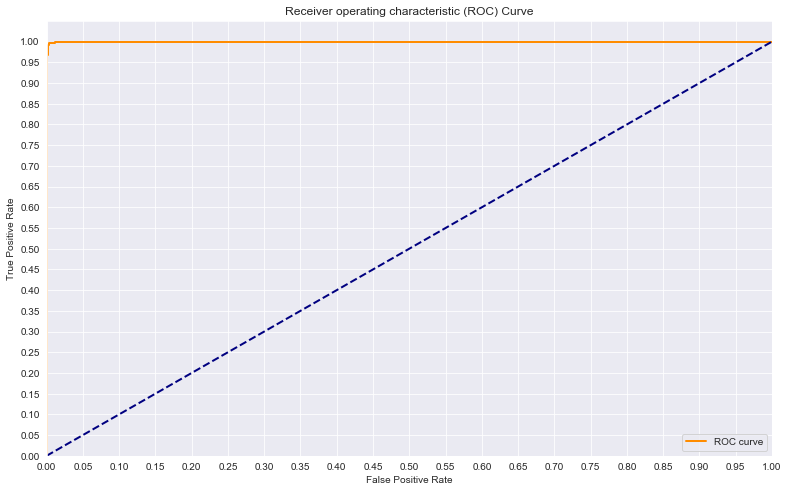

In [17]:
from sklearn.metrics import roc_curve, auc
sns.set_style('darkgrid')

plot_roc(X_test_scaled, y_test)



Ok, that's our base model. Time to tune it.

Since these represent actual people, I'd rather not use SMOTE unless totally necessary.  Let's first try weights

## Addressing Class Imbalance

### Changing Weights

In [18]:
def weight_tests(weights, names, X_train, X_test):
    """
    Input a list of weights and a list of names associated with those weights
    as well as the test and train sets for both X (scaled or unscaled).
    
    The algorithm will run each weight, fit a model using the weight 
    parameters, and print the resulting model.
    
    Then it will run predictions and calculate the y_score, fpr, tpr, and 
    thresholds.  
    
    Next it calculates and prints AUC for each respective name.
    
    Last, it will plot the resulting ROC Curve.
    """
    colors = sns.color_palette('Set2')
    plt.figure(figsize=(13,8))
    
    for n, weight in enumerate(weights):
        # Fit a model
        logreg = LogisticRegression(fit_intercept=False, C=1e20, 
                                    class_weight=weight, solver='lbfgs')
        model_log = logreg.fit(X_train, y_train)
        print(model_log)

        # Predict, calculate y_score, fpr and tpr
        y_hat_test = logreg.predict(X_test)

        y_score = logreg.fit(X_train, y_train).decision_function(X_test)
        
        # Metric Evaluation
        model_eval = print_metrics(y_test, y_hat_test)
        print(f'Metrics = {model_eval}')
        
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        # calculate and print respective AUC scores
        print(f'AUC for {names[n]}: {auc(fpr, tpr)}')
        print('-------------------------------------------------------------')
        lw = 2
        plt.plot(fpr, tpr, color=colors[n],
                 lw=lw, label=f'ROC curve {names[n]}')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

LogisticRegression(C=1e+20, class_weight={0: 1, 1: 1e+20}, fit_intercept=False)
Precision Score: 0.2233586275156714
Recall Score: 1.0
Accuracy Score: 0.741602634467618
F1 Score: 0.36515641855447684
Metrics = None
AUC for 1e20: 0.9849171705515768
-------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 2e+21}, fit_intercept=False)
Precision Score: 0.22313777191825973
Recall Score: 1.0
Accuracy Score: 0.7412733260153678
F1 Score: 0.3648612233899219
Metrics = None
AUC for 20e20: 0.9849126164514067
-------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 3e+22}, fit_intercept=False)
Precision Score: 0.22313777191825973
Recall Score: 1.0
Accuracy Score: 0.7412733260153678
F1 Score: 0.3648612233899219
Metrics = None
AUC for 300e20: 0.9849140177129975
-------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 4e+23}, fit_intercep

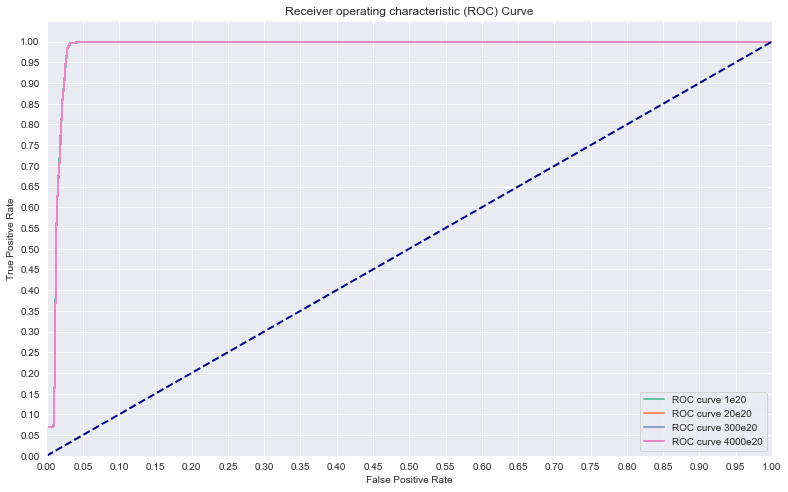

In [19]:
weights = [{0:1, 1:1e20}, {0:1, 1:20e20}, 
           {0:1, 1:300e20}, {0:1, 1:4000e20}]
names = ['1e20', '20e20', '300e20', '4000e20']

weight_tests(weights, names, X_train_scaled, X_test_scaled)

Looks like to get this to work, we're going to need some insanely large weights if we want to balance this out.  Let's go ahead and use SMOTE. We'll re-purpose our previous for ease of use.

### SMOTE

In [20]:
def logreg_smite(ratios, names, X_train, X_test):
    """
    Input a list of ratios and a list of names associated with those weights
    as well as the test and train sets for X (scaled or unscaled).
    
    The algorithm will run each ratio, fit a model using the ratio 
    parameters, and print the resulting model.
    
    Then it will run predictions and calculate the y_score, fpr, tpr, and 
    thresholds.  
    
    After that, it will print the Precision, Recall, Accuracy, and F1 Score
    
    Next it calculates and prints AUC for each respective name.
    
    Last, it will plot the resulting ROC Curve.
    """
    colors = sns.color_palette('Set2')
    plt.figure(figsize=(13,8))
    
    for n, ratio in enumerate(ratios):
        # Fit a model
        smote = SMOTE(sampling_strategy=ratio)
        X_train_resampled, y_train_resampled = smote.fit_sample(X_train, 
                                                                y_train) 
        logreg = LogisticRegression(fit_intercept=False, 
                                    C=1e20, solver ='lbfgs')
        model_log = logreg.fit(X_train_resampled, y_train_resampled)
        print(model_log)

        # Predict, calculate y_score, fpr and tpr
        y_hat_test = logreg.predict(X_test)

        y_score = logreg.fit(X_train, y_train).decision_function(X_test)
        
        # Metric Evaluation
        model_eval = print_metrics(y_test, y_hat_test)
        print(f'Metrics = {model_eval}')
        
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        # calculate and print respective AUC scores
        print(f'AUC for {names[n]}: {auc(fpr, tpr)}')
        print('-------------------------------------------------------------')
        lw = 2
        plt.plot(fpr, tpr, color=colors[n],
                 lw=lw, label=f'ROC curve {names[n]}')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

LogisticRegression(C=1e+20, fit_intercept=False)
Precision Score: 0.1748125161623998
Recall Score: 0.9985228951255539
Accuracy Score: 0.649615806805708
F1 Score: 0.2975352112676056
Metrics = None
AUC for 0.1: 0.9983799664432881
-------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
Precision Score: 0.174496644295302
Recall Score: 0.9985228951255539
Accuracy Score: 0.6488474204171241
F1 Score: 0.29707756537024826
Metrics = None
AUC for 0.25: 0.9983799664432881
-------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
Precision Score: 0.17476732161323683
Recall Score: 0.9985228951255539
Accuracy Score: 0.6495060373216246
F1 Score: 0.29746974697469747
Metrics = None
AUC for 0.33: 0.9983799664432881
-------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
Precision Score: 0.17522032141005703
Recall Score: 0.9985228951255539
Accur

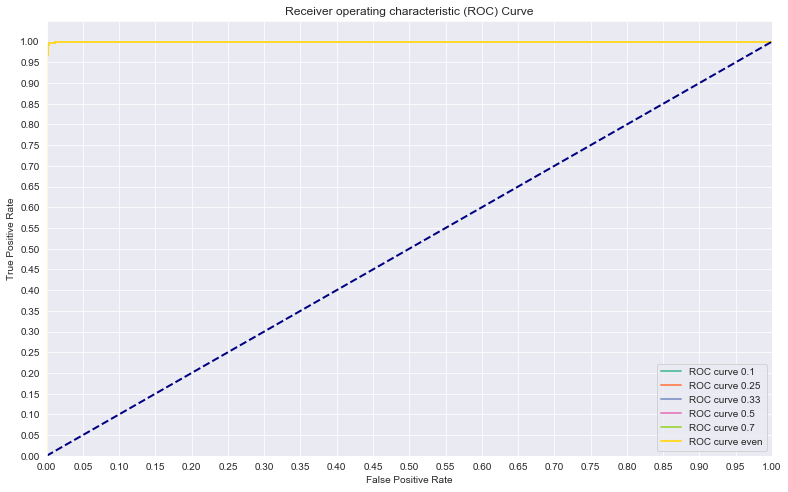

In [21]:
ratios = [0.1, 0.25, 0.33, 0.5, 0.7, 1]
names = ['0.1', '0.25', '0.33','0.5','0.7','even']

logreg_smite(ratios, names, X_train_scaled, X_test_scaled)

## Conclusion:
Although there is a class imbalance problem, Logistic Regression may not be the best method of handling this. Time to move on. 

# Random Forest
Let's start over with a Random Forest.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

scaled_pipeline = Pipeline([('ss', StandardScaler()),
                            ('RF', RandomForestClassifier(random_state=42))])
grid = [{'RF__max_depth': [5], 
         'RF__min_samples_split': [2], 
         'RF__min_samples_leaf': [1]}]

gridsearch = GridSearchCV(estimator=scaled_pipeline, 
                          param_grid=grid, 
                          scoring='recall', 
                          cv=5)
gridsearch.fit(X_train, y_train)

gridsearch.score(X_test, y_test)

0.9985228951255539

Oh, wow... I was not expecting that big of a difference.  Still this is only the Accuracy score. I'd like to see all of the scores since our first model performed so poorly.  Let's also create a new function and find out what the best parameters are.

In [23]:
gridsearch.best_params_

{'RF__max_depth': 5, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}

In [24]:
def params(pipeline, grid):
    """
    Input a pipeline and a parameter grid.
    
    Outputs the best parameters for a model as well as the precision, recall,
    accuracy, and F1 scores for the resulting  cross validated optimization.
    """
    
    scaled_pipeline = pipeline
    scores = ['precision', 'recall', 'accuracy', 'f1']
    for score in scores:
        gridsearch = GridSearchCV(estimator=scaled_pipeline, 
                                  param_grid=grid, 
                                  scoring=score, 
                                  cv=5)
        gridsearch.fit(X_train, y_train)
        print(f'Training {score}: {gridsearch.score(X_train, y_train)}')
        print(f'Test {score}: {gridsearch.score(X_test, y_test)}')
    print(gridsearch.best_params_)

In [25]:
grid = {'RF__criterion': ['gini', 'entropy'],
        'RF__max_depth': [1, 3, 5],
        'RF__min_samples_split': [1, 2, 3],
        'RF__min_samples_leaf': [1]}

params(scaled_pipeline, grid)

Training precision: 1.0
Test precision: 1.0
Training recall: 0.9993438320209974
Test recall: 0.9985228951255539
Training accuracy: 0.9999529500329349
Test accuracy: 0.9998902305159165
Training f1: 0.9996718083360683
Test f1: 0.999260901699926
{'RF__criterion': 'gini', 'RF__max_depth': 3, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}


Alright, so we've narrowed down the minimum sample leaf and split values. Let's just check for the best Max Depth.

In [26]:
max_depth = [5,6,7]
min_samp_splt = [2]
min_samp_leaf = [1]

params(scaled_pipeline, grid)

Training precision: 1.0
Test precision: 1.0
Training recall: 0.9993438320209974
Test recall: 0.9985228951255539
Training accuracy: 0.9999529500329349
Test accuracy: 0.9998902305159165
Training f1: 0.9996718083360683
Test f1: 0.999260901699926
{'RF__criterion': 'gini', 'RF__max_depth': 3, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}


With that, we've found our best combination of parameters! Look how tight those numbers are!

## Confusion Matrix
This still seems too good to be true, so let's check it with a confusion matrix. To go one step further (even though our model was already cross-validated) we're going to validate this ourselves by entering the parameters in manually.

In [27]:
clf_RF = RandomForestClassifier(criterion='gini',
                             max_depth=5,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             random_state=42,
                            class_weight='balanced')

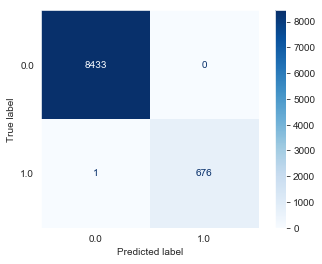

In [28]:
clf_RF.fit(X_train_scaled, y_train)

y_hat_test_rf = clf_RF.predict(X_test_scaled)

sns.set_style('dark')
plot_confusion_matrix(clf_RF, X_test_scaled, y_test, cmap=plt.cm.Blues)

### Comparing Matrices
**Logistic Model's Confusion Matrix Results**
* True Positives = 676
* True Negatives = 5241
* False Positives = 3192
* False Negatives = 1

**Random Forest Model's Confusion Matrix**
* True Positives = 676
* True Negatives = 8443
* False Positives = 0
* False Negatives = 1

Very interesting.  Both models had the exact same number of False Negatives, but the Logistic Regression had a difficult time working through some of the noise and ended up with a lot of False Positives.

As for ***why*** the Stop Resolution plays such an important role, this is a result of a distinction we made during cleaning.  To more easily **distinguish** between **Non-Custodial** Arrests and **Physical** Arrests, we **renamed** of all Stop Resolutions with a value of "Arrest" that **did not also have an Arrest Flag** (indicator of a physical arrest) to "Non-Custodial".  Consequently, there is a **100% correlation** between the **Stop Resolution value "Arrest"** and our **target variable** "Arrest Flag".

This **reinforces** our suggestion that the reports should be more specific and make distinctions between the types of stops (traffic related, officer initiated, response to a call, etc). 

Let's check out the ROC curve of this model.  While we're at it, let's go ahead and modify our plot_roc function to take in a model to make it more generalized.

## Feature Importance
Let's see what features the model determined were most important

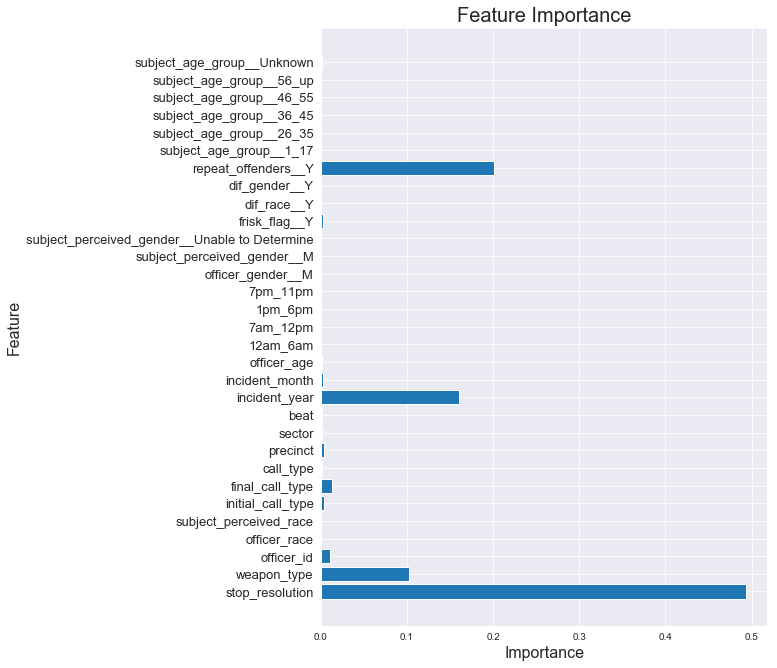

In [29]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    sns.set_style('darkgrid')
    plt.figure(figsize=(8, 11))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values, fontsize=13) 
    plt.xlabel('Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title('Feature Importance', fontsize=20)

plot_feature_importances(clf_RF)

The **greatest features** in order from greatest to least are:
* The reported **Stop Resolution**
* If the **subject** had been **stopped before** (Repeat Offender)
* The **Incident Year**
* The **type of weapon** found on the subject
* The **Final Call Type** (as reported by the officer)

It should be noted that the **officer involved** in the stop plays a role as well.

## ROC Curve

AUC: 0.999261447562777


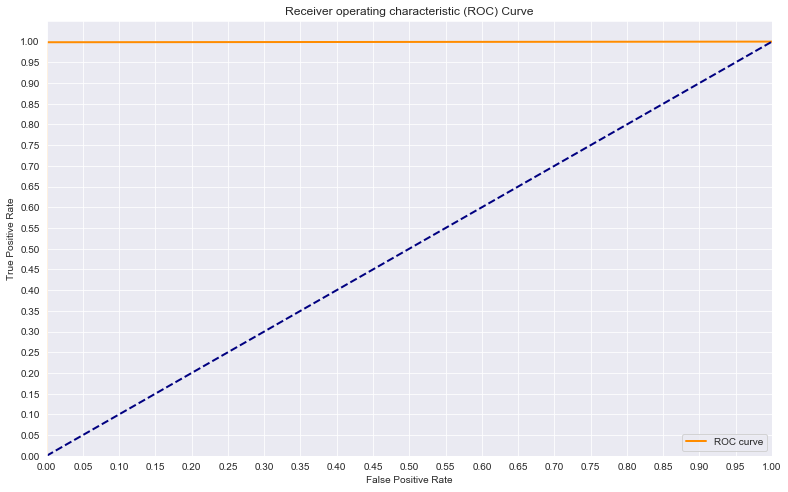

In [30]:
def plot_roc(model, X_test, y_test):
    """
    Input the model, X_test set, the y_test set
    
    The function calculates the y_score, fpr, tpr, and thresholds.
    
    Outputs the Area Under the Curve and a plot of the ROC Curve
    """
    # y_score 
    y_score = model.predict(X_test)
    # False positive rate and true positive rate
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print(f'AUC: {auc(fpr, tpr)}')
    
    plt.figure(figsize=(13, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
plot_roc(clf_RF, X_test_scaled, y_test)

If I didn't see the confusion matrix myself, I wouldn't believe this myself.

Let's checkout some other modeling techniques.

# Decision Tree
We'll take a step backward and try a Decision Tree. We'll also adjust the function we used to make the random forest and generalize it. First, let's just make a vanilla Decision Tree.

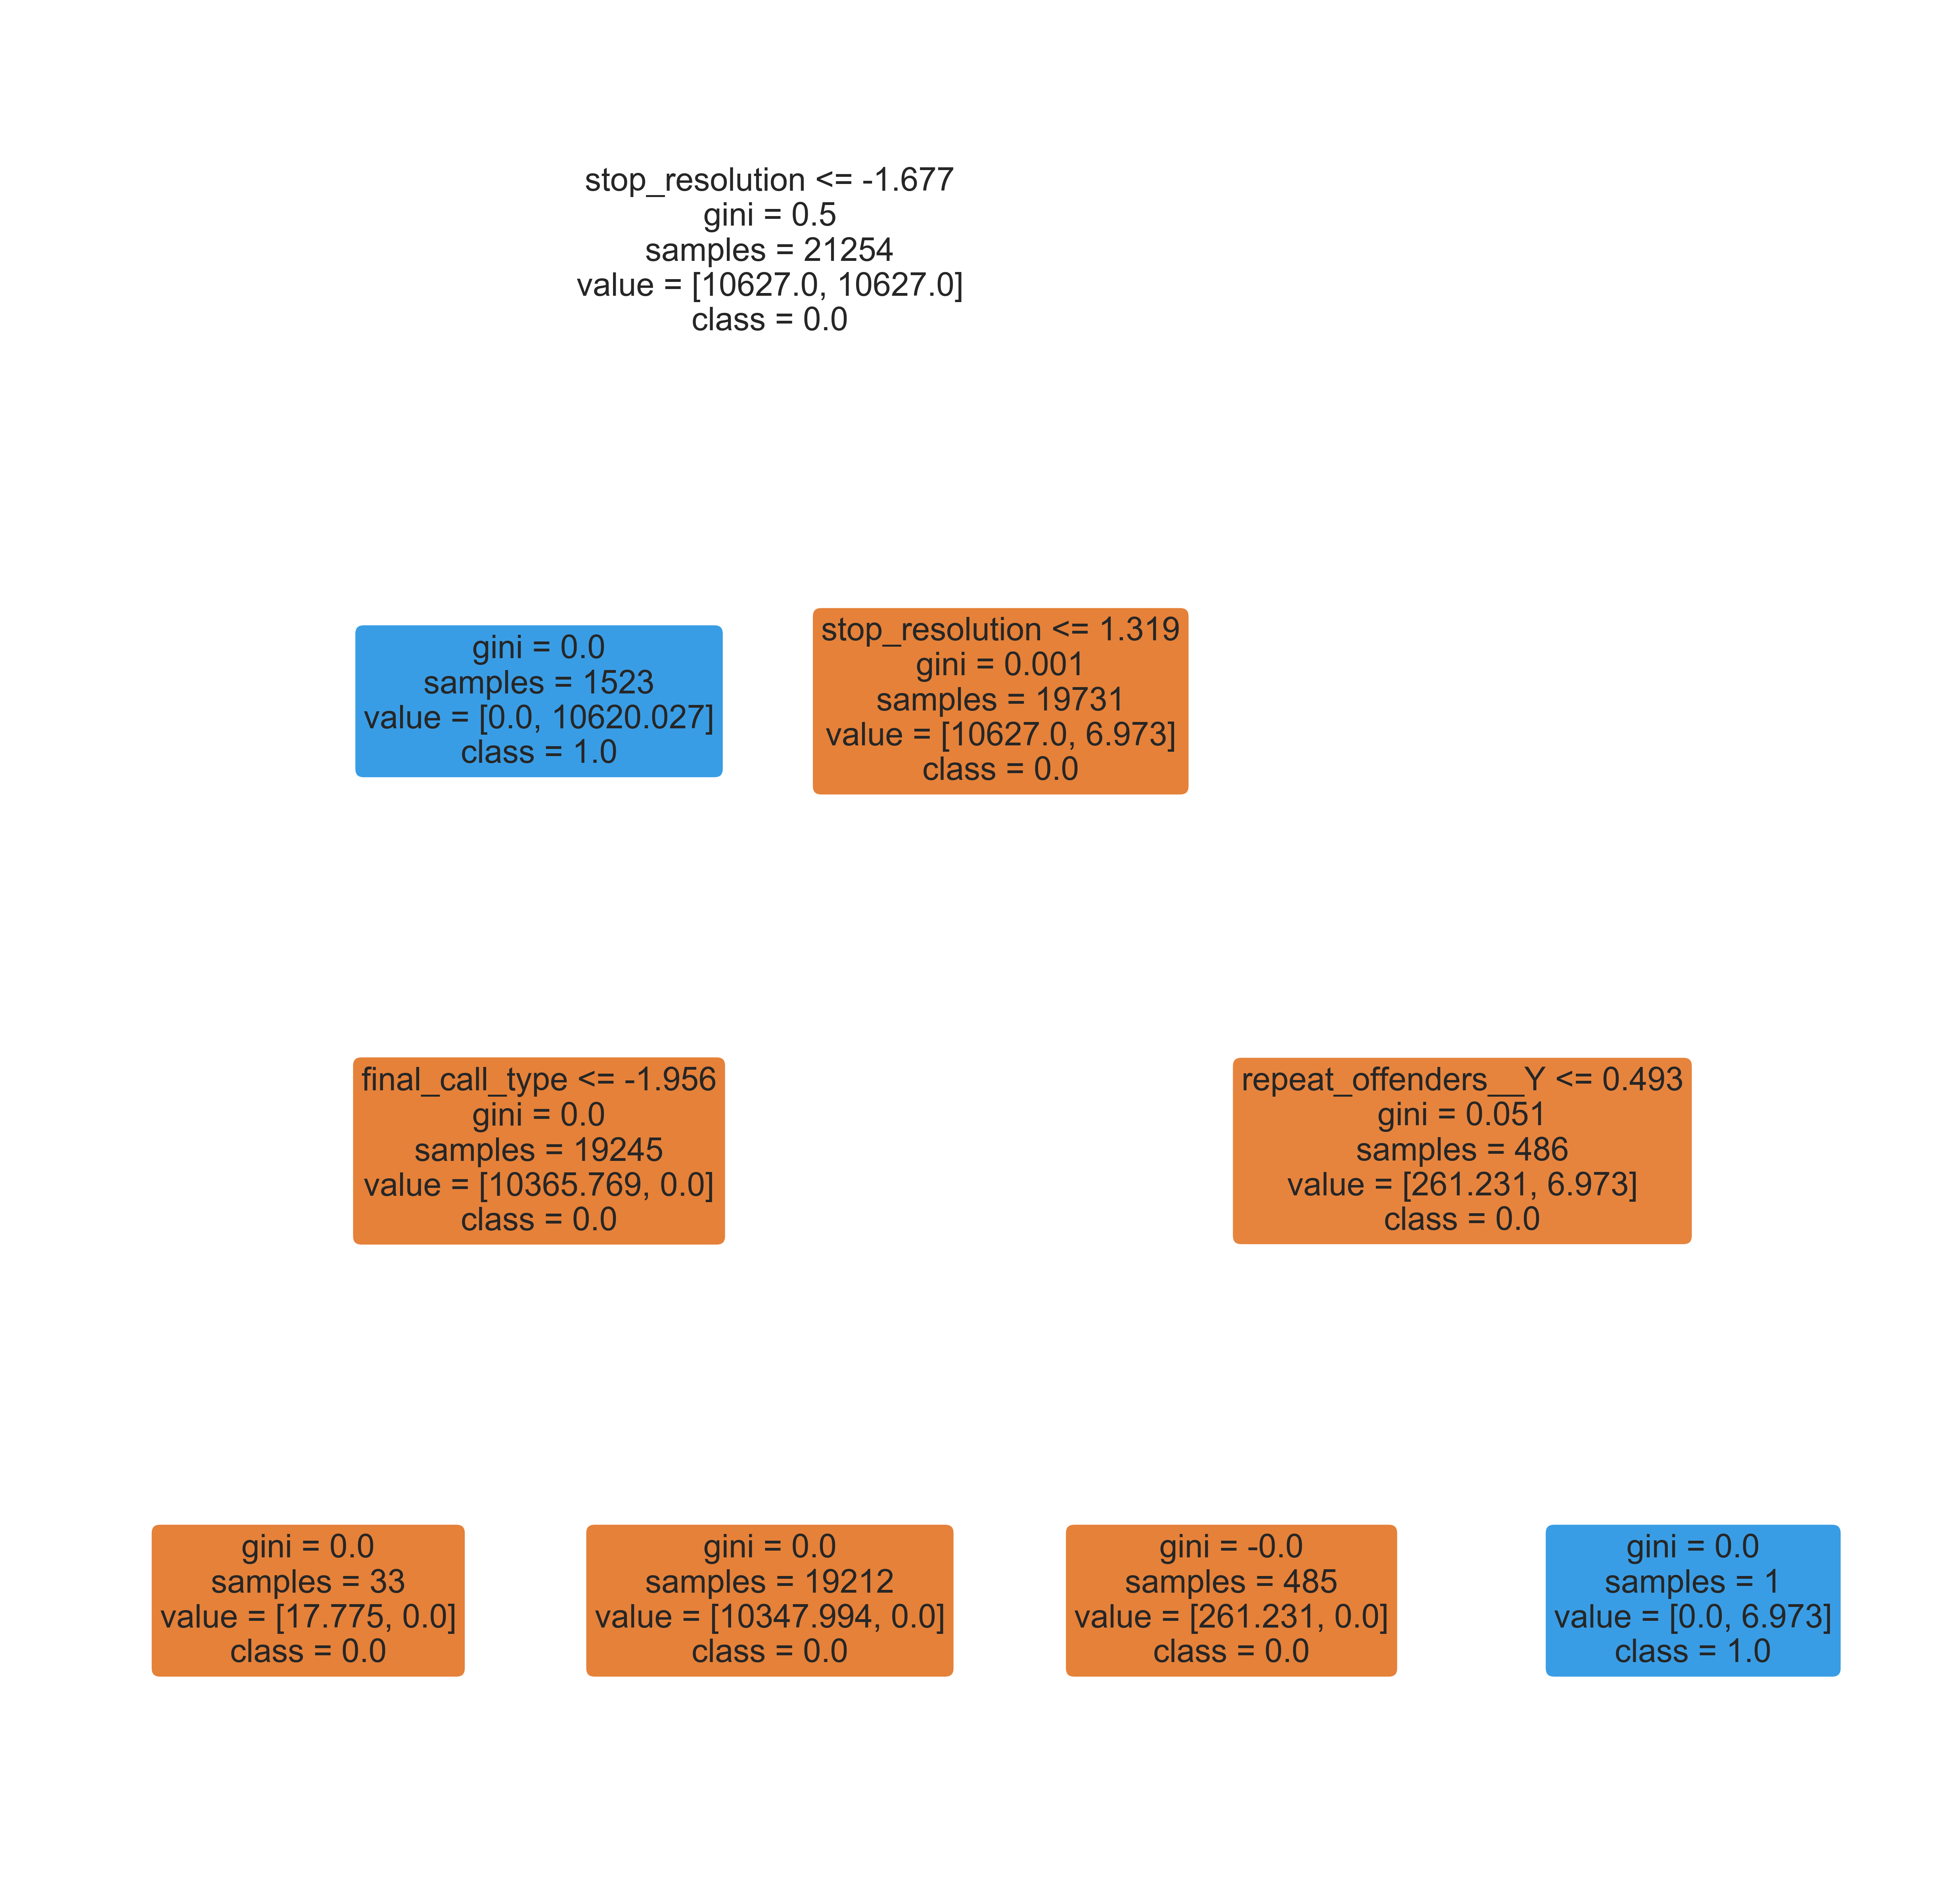

In [31]:
# Train Decision Tree
clf_dt = DecisionTreeClassifier(random_state=42, criterion='gini', 
                             class_weight='balanced')
clf_dt.fit(X_train_scaled, y_train)

# Plotting decision tree


from sklearn import tree
sns.set_style('dark')


plt.figure(figsize=(12,12), dpi=500, edgecolor='black')

tree.plot_tree(clf_dt, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

Well, that was a little disappointing.  Was kinda hoping for something crazy.  Oh, well lets check out performance.

## Metrics & Confusion Matrix

In [32]:
# Calculate the evaluation metrics
y_hat_test_dt = clf_dt.predict(X_test_scaled)

print_metrics(y_test, y_hat_test_dt)

Precision Score: 1.0
Recall Score: 1.0
Accuracy Score: 1.0
F1 Score: 1.0


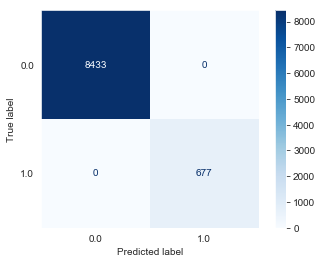

In [33]:
sns.set_style('dark')
plot_confusion_matrix(clf_dt, X_test_scaled, y_test, cmap=plt.cm.Blues)

Well, dang.  It looks like the Decision Tree performed better than the Random Forest.  I don't see an reason to fine-tune the hyper-parameters.  So let's just check out the feature importances and the ROC Curve.

## Feature Importance

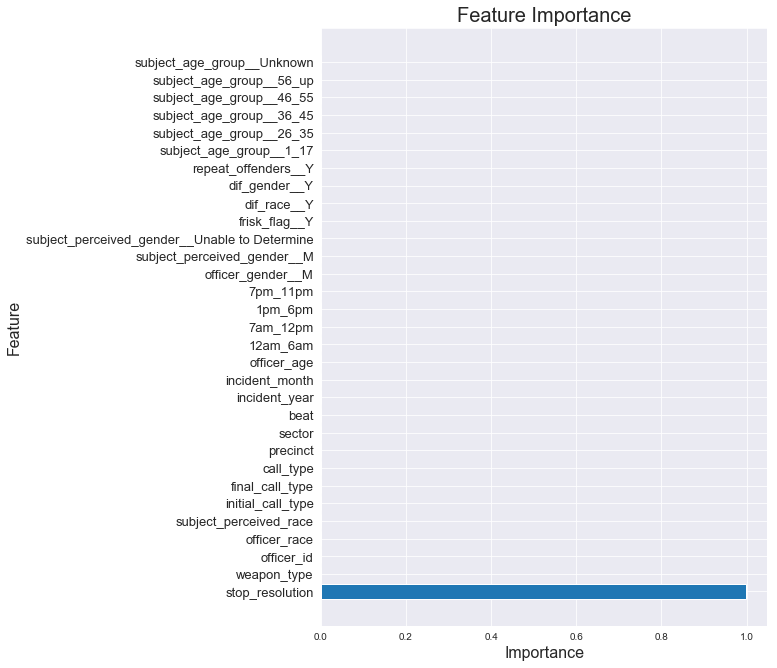

In [34]:
sns.set_style('darkgrid')
plot_feature_importances(clf_dt)

This is interesting.  The Decision Tree determined "Stop Resolution" as the ONLY important feature.  Again, this is probably due to the split we made between physical arrests and non-custodial arrests.

## ROC Curve

AUC: 1.0


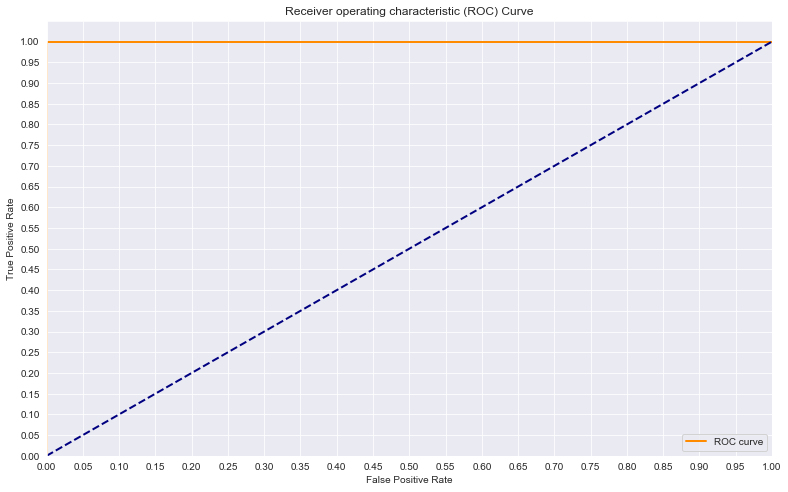

In [35]:
plot_roc(clf_dt, X_test_scaled, y_test)

# K-Nearest Neighbors 
Let's keep moving along and testing out other modeling methods.

In [36]:
# fit the model
scaled_pipeline_knn = Pipeline([('ss', StandardScaler()),
                            ('knn', KNeighborsClassifier())])
scaled_pipeline_knn.fit(X_train, y_train)

#calculate y_hat_test
y_hat_test = scaled_pipeline_knn.predict(X_test)

# print metric evaluation
print_metrics(y_test, y_hat_test)

Precision Score: 0.743455497382199
Recall Score: 0.4194977843426883
Accuracy Score: 0.9461031833150384
F1 Score: 0.5363550519357884


KNN doesn't seem to be a good fit for this data, but let's see what's happening.  High accuracy, but there is a bit of a gap between precision and recall, pointing toward overfitting. Let's look at the the ROC curve and the Confusion Matrix.

## KNN Confusion Matrix and ROC Curve

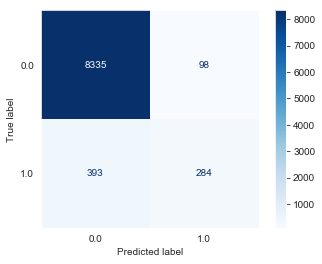

In [37]:
sns.set_style('dark')
plot_confusion_matrix(scaled_pipeline_knn, X_test, y_test, cmap=plt.cm.Blues)

It appears that the high accuracy is almost entirely thanks to the model predicting True Negatives and that's it.

AUC: 0.7039383858272199


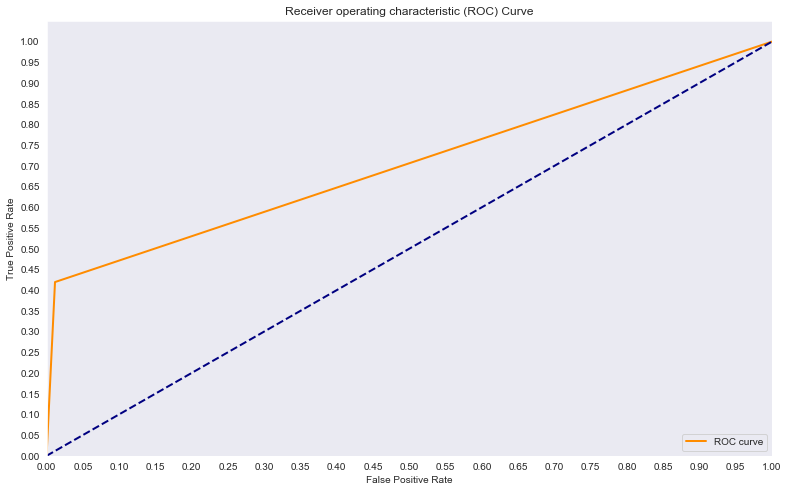

In [38]:
plot_roc(scaled_pipeline_knn, X_test, y_test)

The ROC curve is definitely interesting.  It definitely lines up with the Recall score. Let's see if we can tune this with GridSearchCV

## GridSearchCV
Let's define a grid that we can run our pipeline through.

In [39]:
grid = {'knn__n_neighbors': [3, 5, 11, 19],
        'knn__weights':['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan'],
        'knn__n_jobs': [-1]}

params(scaled_pipeline_knn, grid)

Training precision: 0.9935316946959897
Test precision: 0.9705882352941176
Training recall: 1.0
Test recall: 0.5731166912850812
Training accuracy: 1.0
Test accuracy: 0.9655323819978046
Training f1: 1.0
Test f1: 0.7105263157894737
{'knn__metric': 'manhattan', 'knn__n_jobs': -1, 'knn__n_neighbors': 5, 'knn__weights': 'distance'}


Ok so we've narrowed down a couple of the parameters and our scores have improved a lot.  The divide between Precision and Recall has increased, though. Let's try and tune our grid again.

In [40]:
grid = {'knn__n_neighbors': [9, 11, 13, 15],
        'knn__weights':['distance'],
        'knn__metric': ['manhattan'],
        'knn__n_jobs': [-1]}
params(scaled_pipeline_knn, grid)

Training precision: 1.0
Test precision: 0.968
Training recall: 1.0
Test recall: 0.5642540620384048
Training accuracy: 1.0
Test accuracy: 0.9655323819978046
Training f1: 1.0
Test f1: 0.7087198515769945
{'knn__metric': 'manhattan', 'knn__n_jobs': -1, 'knn__n_neighbors': 11, 'knn__weights': 'distance'}


Well, it appears that this is just the best result we can get from KNN. Let's see the improvements and move on.

## ROC Curve & Confusion Matrix

AUC: 0.7810005042790149


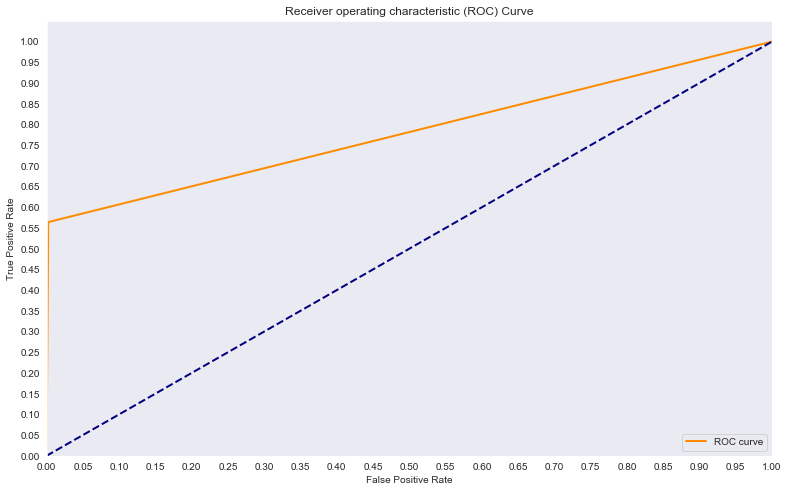

In [41]:
scaled_pipeline_knn = Pipeline([('ss', StandardScaler()),
                            ('knn', KNeighborsClassifier(n_neighbors=11,
                                                         weights='distance',
                                                         metric='manhattan',
                                                         n_jobs=-1))])
scaled_pipeline_knn.fit(X_train, y_train)


plot_roc(scaled_pipeline_knn, X_test, y_test)

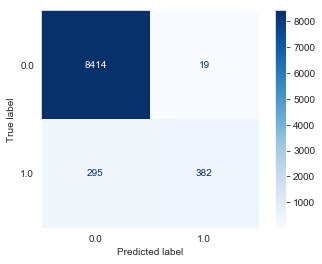

In [42]:
sns.set_style('dark')
plot_confusion_matrix(scaled_pipeline_knn, X_test, y_test, cmap=plt.cm.Blues)

Our True Positives improved a bit, but as you can see, False Negatives are still extremely high.

# XGBoost
Let's try XGBoost out!

In [43]:
scaled_pipeline = Pipeline([('ss', StandardScaler()),
                            ('XG', xgb.XGBClassifier(random_state=42))])
grid = {'XG__learning_rate':[0.1, 0.01, 0.001],
        'XG__max_depth': [3, 5, 7],
        'XG__min_child_weight': [1, 5, 7],
        'XG__n_estimators': [5, 10]}
params(scaled_pipeline, grid)

Training precision: 1.0
Test precision: 1.0
Training recall: 0.9993438320209974
Test recall: 0.9985228951255539
Training accuracy: 0.9999529500329349
Test accuracy: 0.9998902305159165
Training f1: 0.9996718083360683
Test f1: 0.999260901699926
{'XG__learning_rate': 0.1, 'XG__max_depth': 3, 'XG__min_child_weight': 1, 'XG__n_estimators': 5}


## Tuning
Pretty good! Let's look at some other optimizations.

In [44]:
grid = {'XG__learning_rate':[.05, .1, .15, .2],
        'XG__max_depth': [2, 3, 4],
        'XG__min_child_weight': [1],
        'XG__n_estimators': [4, 5, 6]}
params(scaled_pipeline, grid)

Training precision: 1.0
Test precision: 1.0
Training recall: 0.9993438320209974
Test recall: 0.9985228951255539
Training accuracy: 0.9999529500329349
Test accuracy: 0.9998902305159165
Training f1: 0.9996718083360683
Test f1: 0.999260901699926
{'XG__learning_rate': 0.05, 'XG__max_depth': 2, 'XG__min_child_weight': 1, 'XG__n_estimators': 4}


It looks like we've reached our peak performance, but let's try one more time.

In [45]:
grid = {'XG__learning_rate':[.04, .05, .06],
        'XG__max_depth': [1, 2],
        'XG__min_child_weight': [1],
        'XG__n_estimators': [1, 2, 3, 4]}
params(scaled_pipeline, grid)

Training precision: 1.0
Test precision: 1.0
Training recall: 0.9993438320209974
Test recall: 0.9985228951255539
Training accuracy: 0.9999529500329349
Test accuracy: 0.9998902305159165
Training f1: 0.9996718083360683
Test f1: 0.999260901699926
{'XG__learning_rate': 0.04, 'XG__max_depth': 1, 'XG__min_child_weight': 1, 'XG__n_estimators': 1}


Yep, this is peak performance. We can change the parameters all day, but the numbers stay the same. 

Let's check out feature importance, confusion matrix, and ROC Curve. 

## Feature Importance

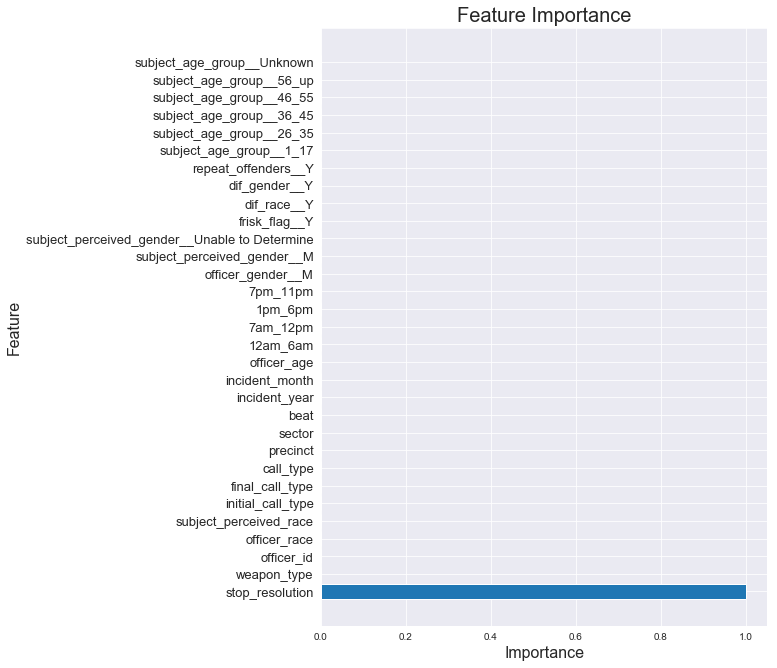

In [46]:
clf_xgb = xgb.XGBClassifier(learning_rate=.04, min_child_weight=1, n_estimators=1, 
                        random_state=42)
clf_xgb.fit(X_train_scaled, y_train)

y_hat_test_x = clf_xgb.predict(X_test_scaled)

plot_feature_importances(clf_xgb)

Much like the Decision Tree, this model only focused on the Stop Resolution.  This is a little frustrating because a model should not be making a prediction based on the result.  It's like making a coin flip prediction after the coin was flipped and revealed.  It's not a prediction.  Let's continue, though.

## Confusion Matrix & ROC Curve

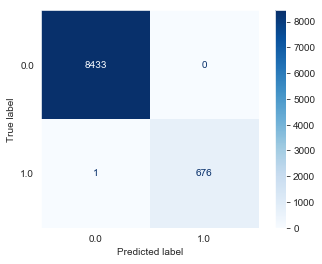

In [47]:
sns.set_style('dark')
plot_confusion_matrix(clf_xgb, X_test_scaled, y_test, cmap=plt.cm.Blues)

These results are identical to our Random Forest Model!

AUC: 0.999261447562777


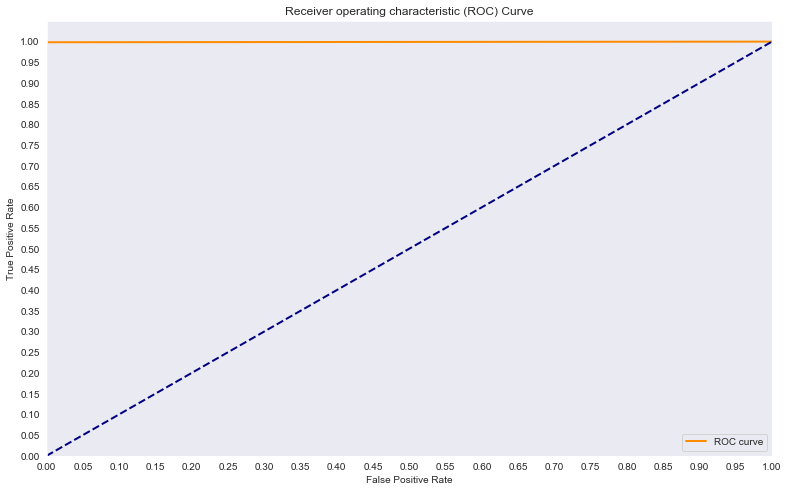

In [48]:
plot_roc(clf_xgb, X_test_scaled, y_test)

# Review

So we've done quite a few of these methods, let's see how their Confusion Matrices line match up:


## Comparing Matrices

Logistic Regression Confusion Matrix


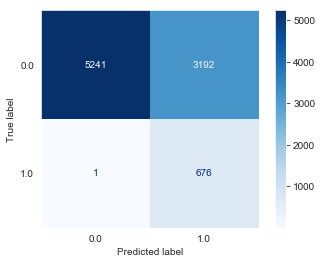

<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002B8049D3E80> None
---------------------------------------------------------------------


Random Forest Model Confusion Matrix


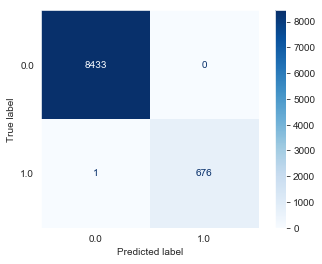

<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002B804A564E0> None
---------------------------------------------------------------------


Decision Tree Confusion Matrix


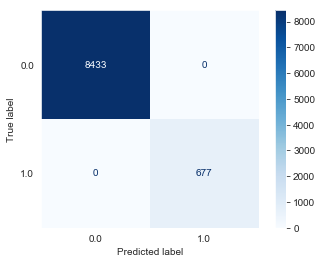

<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002B804C5A320> None
---------------------------------------------------------------------


KNN Model Confusion Matrix


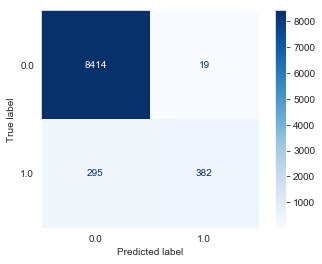

<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002B802599DD8> None
---------------------------------------------------------------------


XGBoost Model Confusion Matrix


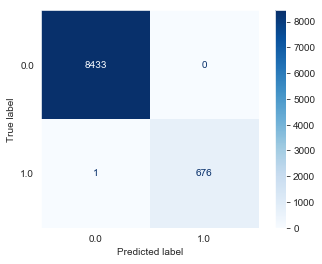

<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002B8024CEF60> None
---------------------------------------------------------------------


In [49]:
# Logistic Model
print('Logistic Regression Confusion Matrix')
print(plot_confusion_matrix(logreg, X_test_scaled, y_test, cmap=plt.cm.Blues), 
      plt.show())
print('---------------------------------------------------------------------')
print('\n')

# Random Forest Model
print("Random Forest Model Confusion Matrix")
print(plot_confusion_matrix(clf_RF, X_test_scaled, y_test, cmap=plt.cm.Blues),
     plt.show())
print('---------------------------------------------------------------------')
print('\n')

# Decision Tree Model
print('Decision Tree Confusion Matrix')
print(plot_confusion_matrix(clf_dt, X_test_scaled, y_test, cmap=plt.cm.Blues),
     plt.show())
print('---------------------------------------------------------------------')
print('\n')

# KNN Model 
print('KNN Model Confusion Matrix')
print(plot_confusion_matrix(scaled_pipeline_knn, X_test, y_test, 
                            cmap=plt.cm.Blues), plt.show())
print('---------------------------------------------------------------------')
print('\n')

# XGBoost Model
print('XGBoost Model Confusion Matrix')
print(plot_confusion_matrix(clf_xgb, X_test_scaled, y_test, cmap=plt.cm.Blues)
      , plt.show())
print('---------------------------------------------------------------------')

Going off of Confusion Matrices alone, it's a three-way tie with the Decision Tree, Random Forest, and XGBoost Model. I say a 'tie' because as I've rerun the kernel and the random sampling has changed during the split, I've observed **all three** of these having **perfect** outcomes for their **respective confusion matrix**  

## Metric Evaluations

Let's confirm this by viewing their respective evaluations.

In [50]:
# Random Forest Model
print("Random Forest Model Metrics")
print(print_metrics(y_test, y_hat_test_rf))
print('---------------------------------------------------------------------')
print('\n')

# Decision Tree Model
print('Decision Tree Metrics')
print(print_metrics(y_test, y_hat_test_dt))
print('---------------------------------------------------------------------')
print('\n')

# XGBoost Model
print('XGBoost Model Metrics')
print(print_metrics(y_test, y_hat_test_x))
print('---------------------------------------------------------------------')

Random Forest Model Metrics
Precision Score: 1.0
Recall Score: 0.9985228951255539
Accuracy Score: 0.9998902305159165
F1 Score: 0.999260901699926
None
---------------------------------------------------------------------


Decision Tree Metrics
Precision Score: 1.0
Recall Score: 1.0
Accuracy Score: 1.0
F1 Score: 1.0
None
---------------------------------------------------------------------


XGBoost Model Metrics
Precision Score: 1.0
Recall Score: 0.9985228951255539
Accuracy Score: 0.9998902305159165
F1 Score: 0.999260901699926
None
---------------------------------------------------------------------


As you can see, the scores are all so close that, only Random Forest and XGBoost have a margin of error depending on how the data is split. The real difference is between the what the models determined were important features.

## Feature Importance

Random Forest Model Metrics


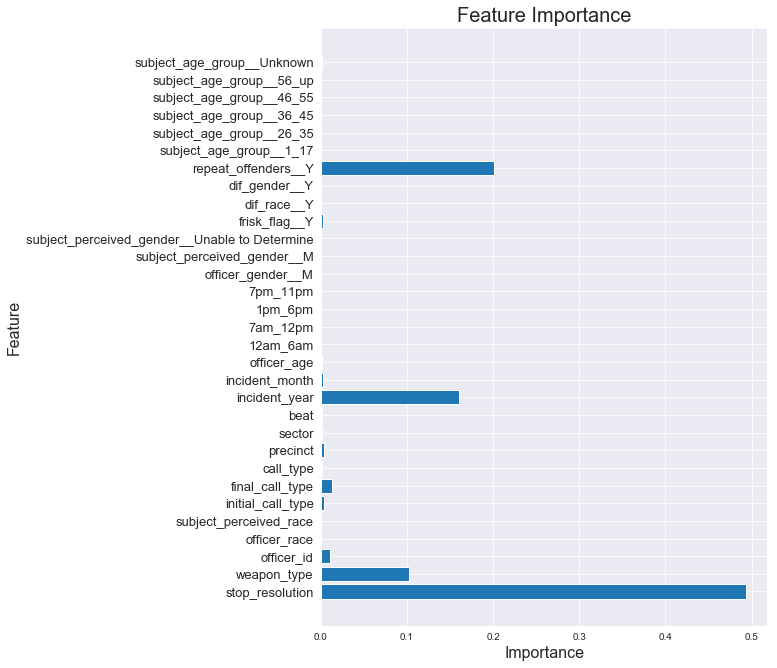

None None
---------------------------------------------------------------------


Decision Tree Metrics


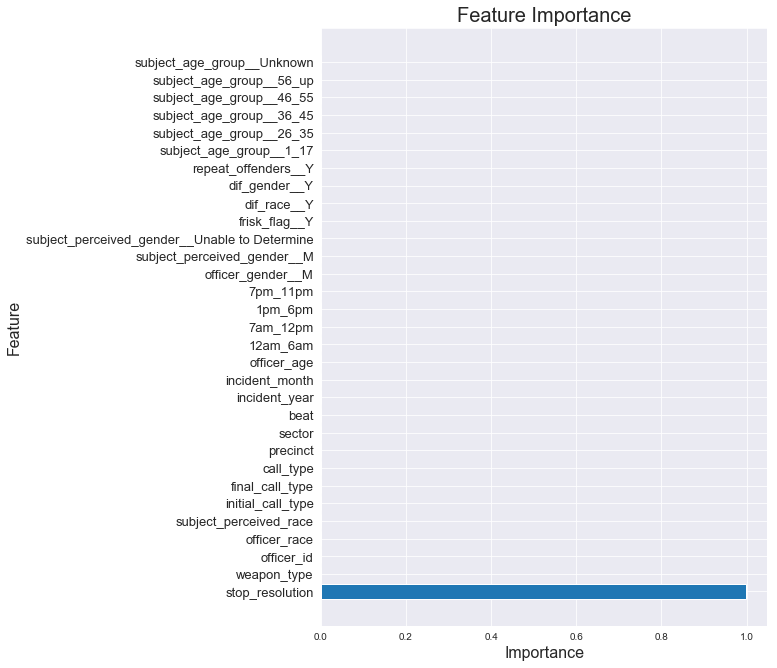

None None
---------------------------------------------------------------------


XGBoost Model Metrics


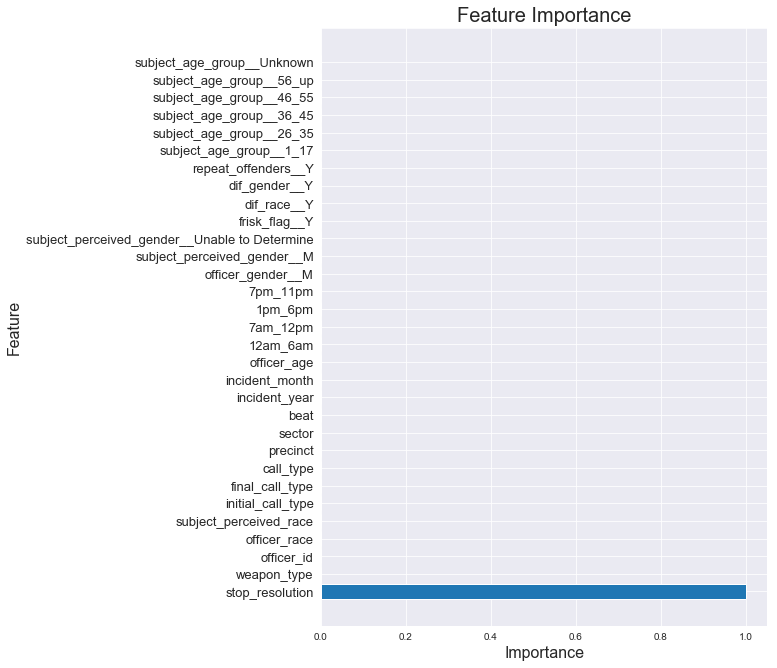

None None
---------------------------------------------------------------------


In [51]:
# Random Forest Model
print("Random Forest Model Metrics")
print(plot_feature_importances(clf_RF), plt.show())
print('---------------------------------------------------------------------')
print('\n')

# Decision Tree Model
print('Decision Tree Metrics')
print(plot_feature_importances(clf_dt), plt.show())
print('---------------------------------------------------------------------')
print('\n')

# XGBoost Model
print('XGBoost Model Metrics')
print(plot_feature_importances(clf_xgb), plt.show())
print('---------------------------------------------------------------------')

## Interpretation:

As you can see, **both** the **Decision Tree** and the **XGBoost** models **heavily focused** on the feature "**Stop_Resolution**".  Again, this is an **accidental by-product** of feature engineering that done to **clarify** the difference between **physical and non-custodial arrests**. The algorithms picked up on this high correlation and zeroed in on it, disregarding the other variables. 

# Conclusion
 
In light of this information, we can say that our **best model for this data set** is actually **Random Forest**.  It is the **only** high performing model that considered other variables.  The reason for this is simply that **the nature of the algorithm** made it so that **some of the trees** in the forest **could not rely on "Stop_Resolution"** and were forced to look into the other features.

For some future work, we'd like to experiment with these same models, but dropping the "Stop_Resolution" columns.

The very fact, however, that these models only focused on so few of the features shows us that the current reporting system is too generalized and/or redundant.  Revision of the reporting system should be considered if the police department wants a more accurate measurement of police interactions with the public during a Terry Stop. 